In [ ]:
!rm -rf *.png out.zip

In [ ]:
opt_name = "clip"

#Fold vs Prune and Ablations

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from pathlib import Path
import seaborn as sns

# Load text content
with open(f"fold-noe", "r") as f:
    fold_text = f.read()
with open(f"mag-l1-noe", "r") as f:
    mag1_text = f.read()
with open(f"mag-l2-noe", "r") as f:
    mag2_text = f.read()

360 360 360


/tmp/ipython-input-1418126154.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


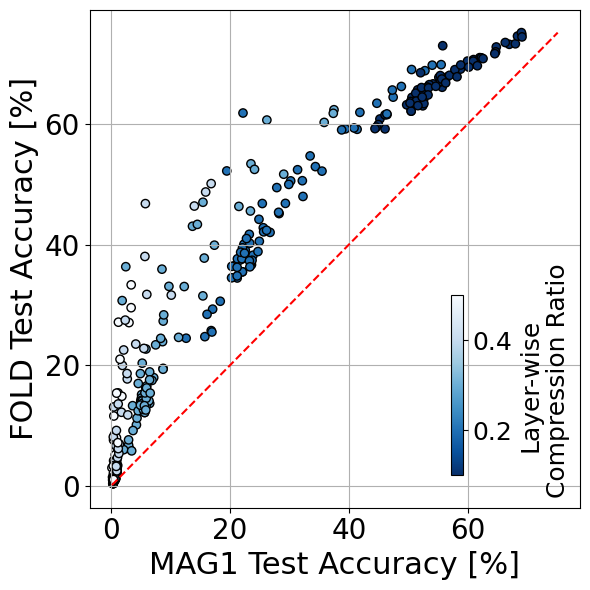

/tmp/ipython-input-1418126154.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


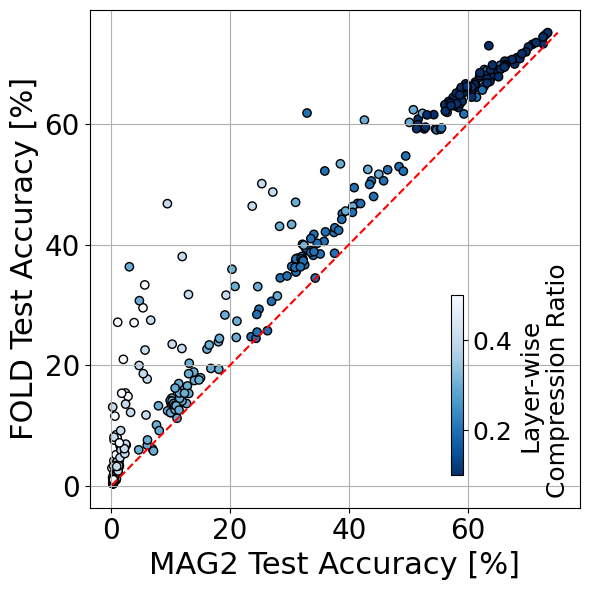

In [ ]:
import re
import pandas as pd

def extract_before_after_with_id(text):
    # Match each [MODEL] block
    pattern = re.compile(r"\[MODEL\]\s+(\d+)/\d+.*?([^\s]+\.pt)(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []
    for match in pattern.finditer(text):
        model_id = match.group(1)
        model_name = match.group(2)
        block = match.group(3)

        # Baseline (RATIO=0.0, EVENT=BASE)
        base_match = re.search(r"RATIO=0\.0\s+EVENT=BASE[^\n]*acc=([0-9.]+)", block)
        if not base_match:
            continue
        acc_before = float(base_match.group(1))

        # REPAIR events for other ratios
        # Match lines like "RATIO=0.1 EVENT=PRUNE acc=93.33"
        repair_pattern = r"RATIO=([0-9.]+)\s+EVENT=PRUNE[^\n]*acc=([0-9.]+)"
        for ratio_str, acc_after_str in re.findall(repair_pattern, block):
            entries.append((
                model_id,
                model_name,
                float(ratio_str),
                acc_before,
                float(acc_after_str)
            ))

    return pd.DataFrame(entries, columns=["model_id", "model", "ratio", "acc_before", "acc_after"])


def plot_compration_ratio_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Reduce
    y_df = y_df[["model_id", "model", "ratio", "acc_y"]]
    x_df = x_df[["model_id", "model", "ratio", "acc_x"]]
    # Merge
    merged_df = pd.merge(y_df, x_df, on=["model_id", "model", "ratio"])

    norm = plt.Normalize(merged_df["ratio"].min(), merged_df["ratio"].max())
    cmap = cm.Blues_r

    # Plot with doubled font sizes
    fig, ax = plt.subplots(figsize=(6, 6))

    scatter = ax.scatter(
        merged_df["acc_x"], merged_df["acc_y"],
        c=merged_df["ratio"], cmap=cmap, norm=norm,
        marker='o', edgecolor='black'
    )

    min_val = merged_df[["acc_x", "acc_y"]].min().min()
    max_val = merged_df[["acc_x", "acc_y"]].max().max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")

    # Axis labels
    ax.set_xlabel(f"{x_name} Test Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Test Accuracy [%]", fontsize=22)

    # Tick labels
    ax.tick_params(axis='both', labelsize=20)

    # Colorbar
    cbar_ax = fig.add_axes([0.76, 0.20, 0.02, 0.3])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Grid and layout
    ax.grid(True)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__compression_ratio_scatter__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_before_after_with_id(fold_text)
mag1_df = extract_before_after_with_id(mag1_text)
mag2_df = extract_before_after_with_id(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_compration_ratio_scatter(mag2_df, fold_df, "MAG2", "FOLD")


360 360 360


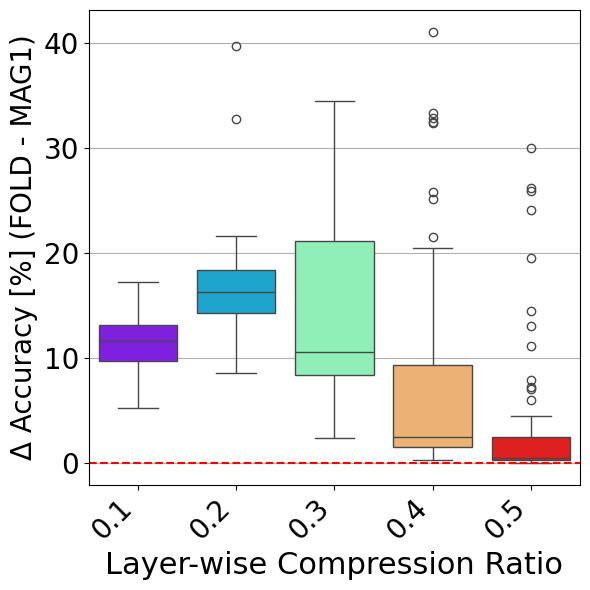

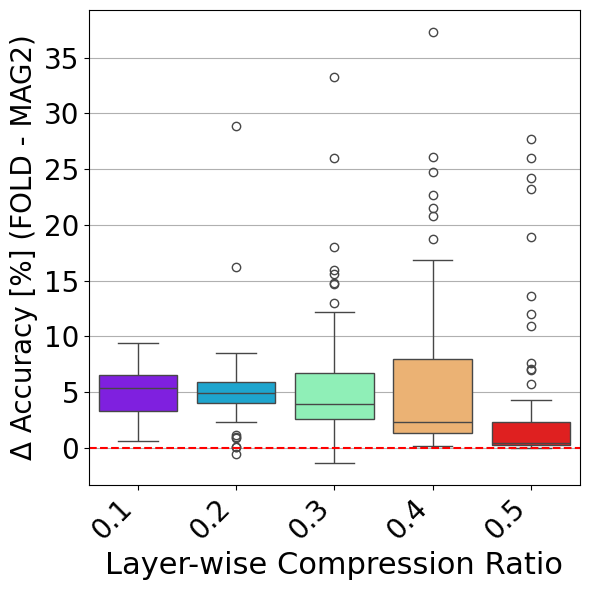

In [ ]:
def extract_with_relative_accuracy(text):
    # Match each model block
    pattern = re.compile(r"\[MODEL\] (\d+)/\d+\s+(.*?)\.pt(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []

    for match in pattern.finditer(text):
        model_name = match.group(2).strip()
        block = match.group(3)

        # Extract BASE (before pruning) and REPAIR (after repair)
        before = re.findall(r"RATIO=([0-9.]+)\s+EVENT=BASE params=(\d+)\s+acc=([0-9.]+)", block)
        # after = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)

        if before:
            base_ratio, base_params, base_acc = before[0]
            base_params = int(base_params)
            base_acc = float(base_acc)

            # Match each PRUNE ratio and corresponding REPAIR accuracy
            prunes = re.findall(r"RATIO=([0-9.]+)\s+EVENT=PRUNE params=(\d+)\s+acc=([0-9.]+)", block)
            repairs = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)

            for (r_p, p_p, acc_r), (r_r, _) in zip(prunes, repairs):
                if abs(float(r_p) - float(r_r)) < 1e-4 and base_acc >= 70.0:
                    sparsity = round(1.0 - int(p_p) / base_params, 2)
                    entries.append((model_name, sparsity, float(r_p), base_acc, float(acc_r)))

    return pd.DataFrame(entries, columns=["model", "sparsity", "ratio", "acc_before", "acc_after"])


# Extract data
def plot_compration_ratio_hist(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Merge
    merged_df = pd.merge(y_df[["model", "ratio", "acc_y"]], x_df[["model", "ratio", "acc_x"]], on=["model", "ratio"])

    # Compute relative difference
    merged_df["diff"] = merged_df["acc_y"] - merged_df["acc_x"]
    boxplot_df = merged_df[["ratio", "diff"]].copy()

    # Get sorted unique sparsities
    unique_sparsities = sorted(boxplot_df["ratio"].unique())
    cmap = colormaps["Blues_r"]
    palette = [cmap(0.3 + 0.6 * i / max(len(unique_sparsities) - 1, 1)) for i in range(len(unique_sparsities))]
    palette_dict = dict(zip(unique_sparsities, palette))

    # Plotting with increased font sizes
    fig = plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=boxplot_df,
        x="ratio",
        y="diff",
        hue="ratio",
        palette="rainbow",
        dodge=False,
        legend=False
    )

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Layer-wise Compression Ratio", fontsize=22)
    plt.ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True, axis='y')
    # plt.ylim(-30, 40)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__compression_ratio_hist__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_with_relative_accuracy(fold_text)
mag1_df = extract_with_relative_accuracy(mag1_text)
mag2_df = extract_with_relative_accuracy(mag2_text)

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_hist(mag1_df.copy(), fold_df.copy(), "MAG1", "FOLD")
plot_compration_ratio_hist(mag2_df, fold_df, "MAG2", "FOLD")


#Fine-tune Only LN

360 360 360


/tmp/ipython-input-196102554.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


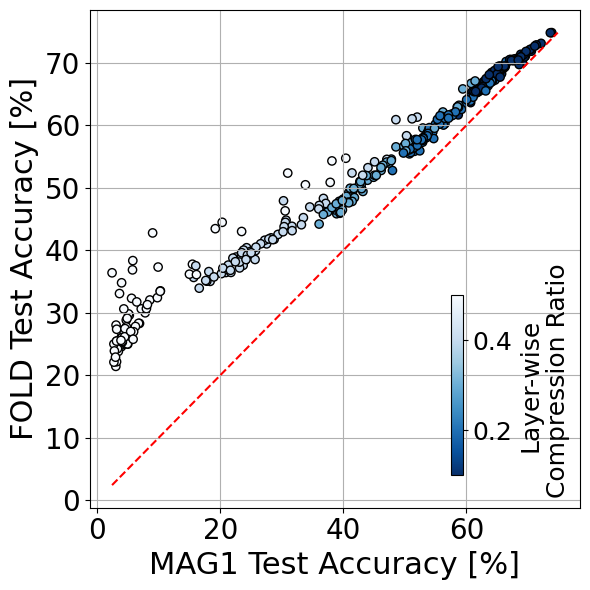

/tmp/ipython-input-196102554.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


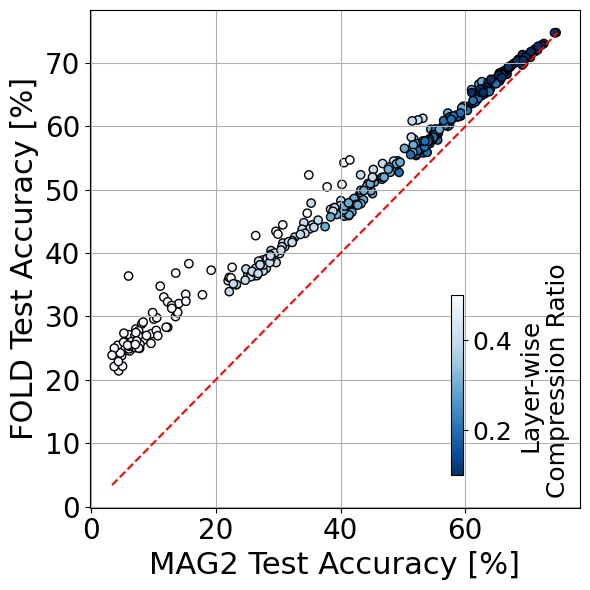

In [ ]:
import re
import pandas as pd

def extract_before_after_with_id(text):
    # Match each [MODEL] block
    pattern = re.compile(r"\[MODEL\]\s+(\d+)/\d+.*?([^\s]+\.pt)(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []
    for match in pattern.finditer(text):
        model_id = match.group(1)
        model_name = match.group(2)
        block = match.group(3)

        # Baseline (RATIO=0.0, EVENT=BASE)
        base_match = re.search(r"RATIO=0\.0\s+EVENT=BASE[^\n]*acc=([0-9.]+)", block)
        if not base_match:
            continue
        acc_before = float(base_match.group(1))

        # REPAIR events for other ratios
        # Match lines like "RATIO=0.1 EVENT=REPAIR acc=93.33"
        repair_pattern = r"RATIO=([0-9.]+)\s+EVENT=REPAIR[^\n]*acc=([0-9.]+)"
        for ratio_str, acc_after_str in re.findall(repair_pattern, block):
            entries.append((
                model_id,
                model_name,
                float(ratio_str),
                acc_before,
                float(acc_after_str)
            ))

    return pd.DataFrame(entries, columns=["model_id", "model", "ratio", "acc_before", "acc_after"])


def plot_compration_ratio_scatter(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Reduce
    y_df = y_df[["model_id", "model", "ratio", "acc_y"]]
    x_df = x_df[["model_id", "model", "ratio", "acc_x"]]
    # Merge
    merged_df = pd.merge(y_df, x_df, on=["model_id", "model", "ratio"])

    norm = plt.Normalize(merged_df["ratio"].min(), merged_df["ratio"].max())
    cmap = cm.Blues_r

    # Plot with doubled font sizes
    fig, ax = plt.subplots(figsize=(6, 6))

    scatter = ax.scatter(
        merged_df["acc_x"], merged_df["acc_y"],
        c=merged_df["ratio"], cmap=cmap, norm=norm,
        marker='o', edgecolor='black'
    )

    min_val = merged_df[["acc_x", "acc_y"]].min().min()
    max_val = merged_df[["acc_x", "acc_y"]].max().max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")

    # Axis labels
    ax.set_xlabel(f"{x_name} Test Accuracy [%]", fontsize=22)
    ax.set_ylabel(f"{y_name} Test Accuracy [%]", fontsize=22)

    # Tick labels
    ax.tick_params(axis='both', labelsize=20)

    # Colorbar
    cbar_ax = fig.add_axes([0.76, 0.20, 0.02, 0.3])
    smap = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(smap, cax=cbar_ax, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Grid and layout
    ax.grid(True)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__ftLN__compression_ratio_scatter__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_before_after_with_id(fold_text)
mag1_df = extract_before_after_with_id(mag1_text)
mag2_df = extract_before_after_with_id(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_scatter(mag1_df, fold_df, "MAG1", "FOLD")
plot_compration_ratio_scatter(mag2_df, fold_df, "MAG2", "FOLD")


360 360 360


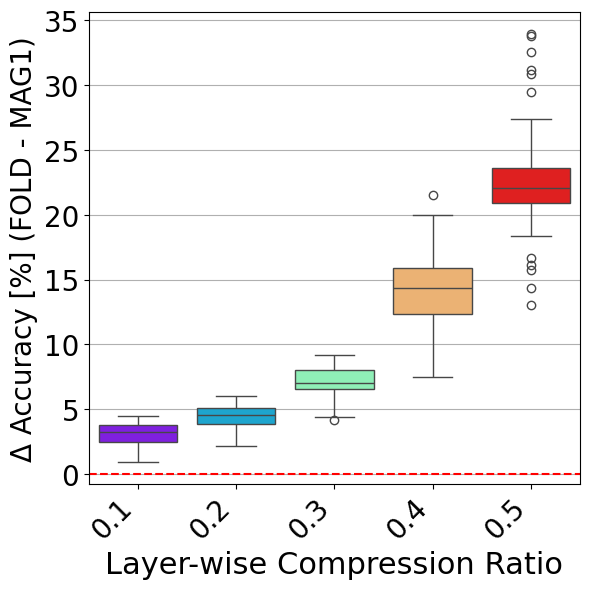

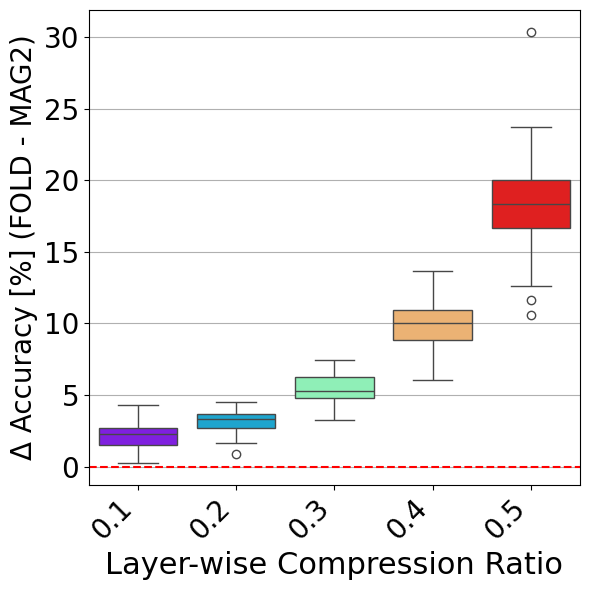

In [ ]:
def extract_with_relative_accuracy(text):
    # Match each model block
    pattern = re.compile(r"\[MODEL\] (\d+)/\d+\s+(.*?)\.pt(.*?)(?=\[MODEL\]|\Z)", re.DOTALL)
    entries = []

    for match in pattern.finditer(text):
        model_name = match.group(2).strip()
        block = match.group(3)

        # Extract BASE (before pruning) and REPAIR (after repair)
        before = re.findall(r"RATIO=([0-9.]+)\s+EVENT=BASE params=(\d+)\s+acc=([0-9.]+)", block)
        # after = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)

        if before:
            base_ratio, base_params, base_acc = before[0]
            base_params = int(base_params)
            base_acc = float(base_acc)

            # Match each PRUNE ratio and corresponding REPAIR accuracy
            prunes = re.findall(r"RATIO=([0-9.]+)\s+EVENT=PRUNE params=(\d+)\s+acc=([0-9.]+)", block)
            repairs = re.findall(r"RATIO=([0-9.]+)\s+EVENT=REPAIR acc=([0-9.]+)", block)

            for (r_p, p_p, _), (r_r, acc_r) in zip(prunes, repairs):
                if abs(float(r_p) - float(r_r)) < 1e-4 and base_acc >= 70.0:
                    sparsity = round(1.0 - int(p_p) / base_params, 2)
                    entries.append((model_name, sparsity, float(r_p), base_acc, float(acc_r)))

    return pd.DataFrame(entries, columns=["model", "sparsity", "ratio", "acc_before", "acc_after"])


# Extract data
def plot_compration_ratio_hist(x_df, y_df, x_name, y_name):
    # Rename
    x_df = x_df.rename(columns={"acc_after": "acc_x"})
    y_df = y_df.rename(columns={"acc_after": "acc_y"})
    # Merge
    merged_df = pd.merge(y_df[["model", "ratio", "acc_y"]], x_df[["model", "ratio", "acc_x"]], on=["model", "ratio"])

    # Compute relative difference
    merged_df["diff"] = merged_df["acc_y"] - merged_df["acc_x"]
    boxplot_df = merged_df[["ratio", "diff"]].copy()

    # Get sorted unique sparsities
    unique_sparsities = sorted(boxplot_df["ratio"].unique())
    cmap = colormaps["Blues_r"]
    palette = [cmap(0.3 + 0.6 * i / max(len(unique_sparsities) - 1, 1)) for i in range(len(unique_sparsities))]
    palette_dict = dict(zip(unique_sparsities, palette))

    # Plotting with increased font sizes
    fig = plt.figure(figsize=(6, 6))
    sns.boxplot(
        data=boxplot_df,
        x="ratio",
        y="diff",
        hue="ratio",
        palette="rainbow",
        dodge=False,
        legend=False
    )

    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Layer-wise Compression Ratio", fontsize=22)
    plt.ylabel(f"Δ Accuracy [%] ({y_name} - {x_name})", fontsize=20)

    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True, axis='y')
    # plt.ylim(-30, 40)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{opt_name}__ftLN__compression_ratio_hist__{x_name}_vs_{y_name}.png", dpi=100)


# Extract
fold_df = extract_with_relative_accuracy(fold_text)
mag1_df = extract_with_relative_accuracy(mag1_text)
mag2_df = extract_with_relative_accuracy(mag2_text)

# Print
print(len(fold_df), len(mag1_df), len(mag2_df))

plot_compration_ratio_hist(mag1_df.copy(), fold_df.copy(), "MAG1", "FOLD")
plot_compration_ratio_hist(mag2_df, fold_df, "MAG2", "FOLD")


#Full Fine-tuning

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps
from pathlib import Path
import seaborn as sns


method_name = "clip"

# Load text content
with open(f"fold", "r") as f:
    fold_text = f.read()
with open(f"mag-l1", "r") as f:
    mag1_text = f.read()
with open(f"mag-l2", "r") as f:
    mag2_text = f.read()

568 540 576


/tmp/ipython-input-3516055984.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


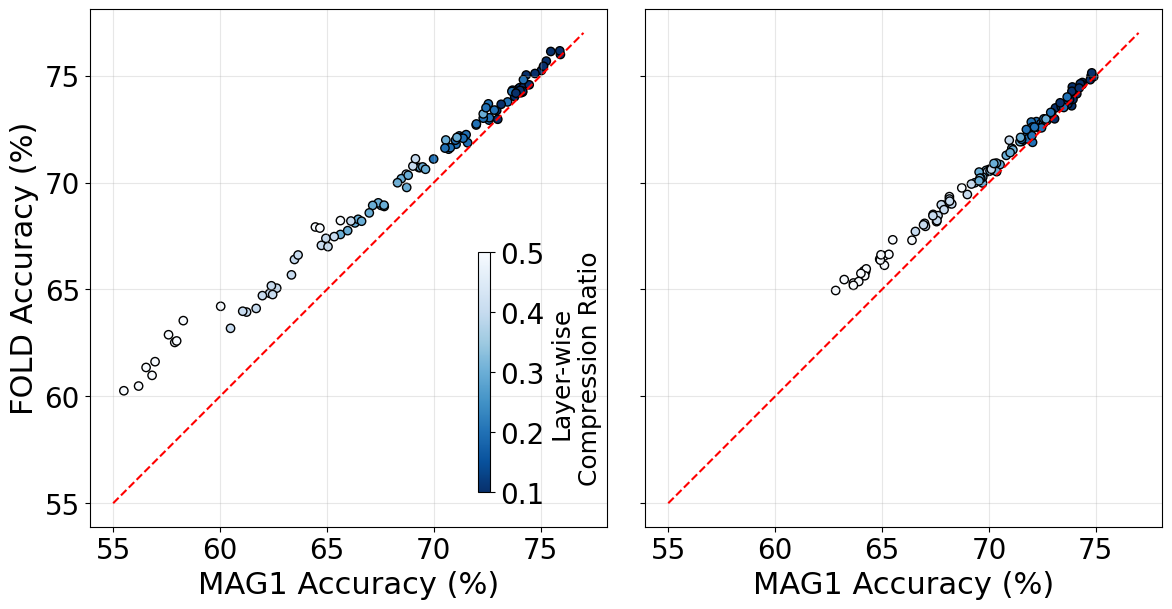

/tmp/ipython-input-3516055984.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


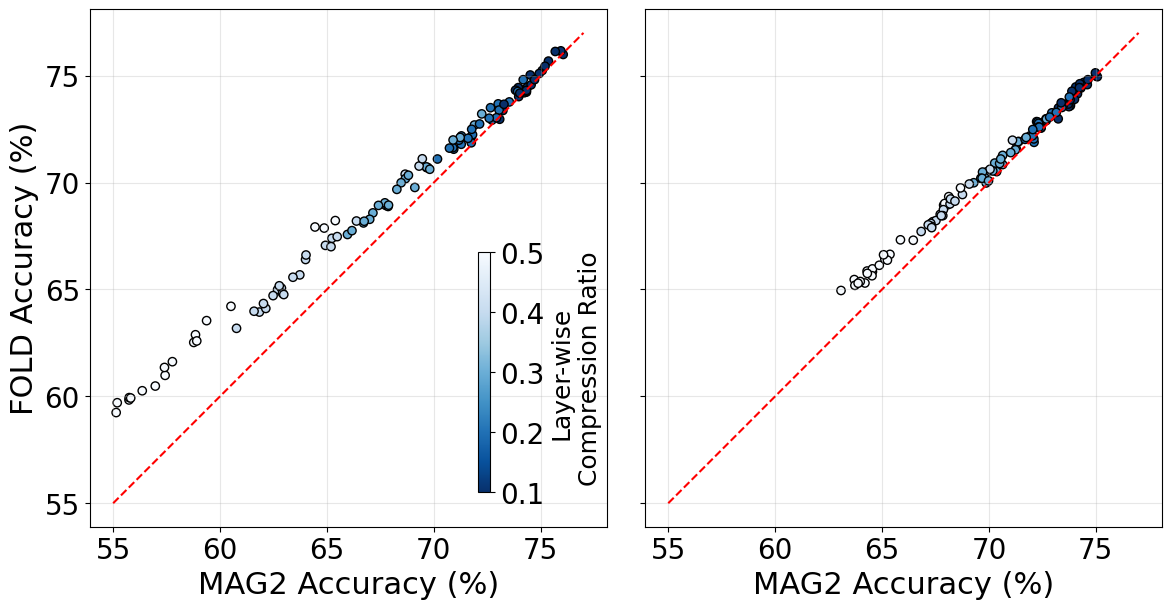

In [ ]:
import re, pandas as pd

def parse_epoch_acc(text):
    """
    Extracts: model_id, ratio, epoch, acc (from FINETUNE_EPOCH events)
    """
    parts = re.split(r"\[MODEL\] (\d+)/\d+ .*?\.pt", text)[1:]
    records = []
    for i in range(0, len(parts), 2):
        model_id = int(parts[i])
        block = parts[i + 1]
        for m in re.finditer(r"RATIO=([\d.]+)\s+EVENT=FINETUNE_EPOCH(\d+)\s+acc=([\d.]+)", block):
            records.append({
                "model_id": model_id,
                "ratio": float(m.group(1)),
                "epoch": int(m.group(2)),
                "acc": float(m.group(3))
            })
    return pd.DataFrame(records)


# -------- Extract data for both methods --------
fold_df = parse_epoch_acc(fold_text)
mag1_df = parse_epoch_acc(mag1_text)
mag2_df = parse_epoch_acc(mag2_text)

print(len(fold_df), len(mag1_df), len(mag2_df))

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    # Merge by model_id, ratio, epoch
    merged = pd.merge(
        fold_df, method_df,
        on=["model_id", "ratio", "epoch"],
        suffixes=("_fold", "")
    )

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    cmap = cm.Blues_r
    norm = mcolors.Normalize(vmin=merged["ratio"].min(), vmax=merged["ratio"].max())

    for i, epoch in enumerate([1, 5]):
        ax = axes[i]
        data = merged[merged["epoch"] == epoch]
        lo = 55
        hi = 77
        data = data[data["acc"]>lo]
        data = data[data["acc_fold"]>lo]
        data = data[data["acc"]<hi]
        data = data[data["acc_fold"]<hi]

        sc = ax.scatter(data["acc"], data["acc_fold"],
                        c=cmap(norm(data["ratio"].values)), edgecolors="black")

        # Diagonal y=x
        # lo = min(data["acc"].min(), data["acc_fold"].min())
        # hi = max(data["acc"].max(), data["acc_fold"].max())
        ax.plot([lo, hi], [lo, hi], 'r--', alpha=1.0)

        ax.set_xlabel(f"{method_name} Accuracy (%)", fontsize=22)
        if i == 0:
            ax.set_ylabel("FOLD Accuracy (%)", fontsize=22)

        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(axis='both', which='major', labelsize=20)

        ax.grid(True, alpha=0.3)

    # Colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cax = fig.add_axes([0.41, 0.17, 0.01, 0.4])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=20)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft.png", dpi=100)
    plt.show()

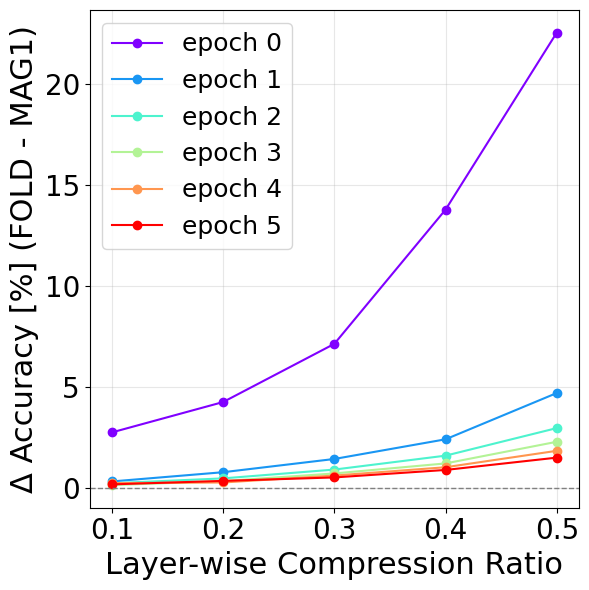

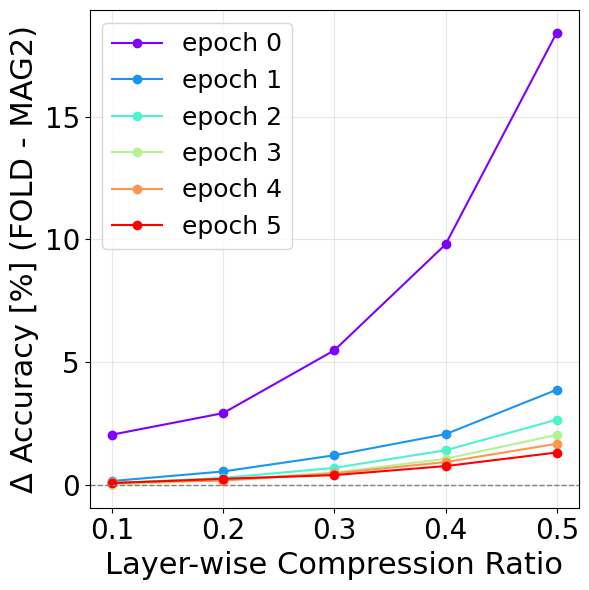

In [ ]:
def parse_epoch_acc(text):
    """Extract test accuracy for REPAIR (epoch 0) and FINETUNE_EPOCHx (epochs 1-5)."""
    records = []
    blocks = re.split(r"\[MODEL\]\s+(\d+)/\d+\s+.*?\.pt", text)[1:]

    for i in range(0, len(blocks), 2):
        model_id = int(blocks[i])
        ratio = None
        for line in blocks[i + 1].splitlines():
            m_ratio = re.search(r"RATIO=([\d.]+)", line)
            if m_ratio: ratio = float(m_ratio.group(1))

            if "EVENT=REPAIR" in line:
                acc = re.search(r"acc=([\d.]+)", line)
                if acc: records.append((model_id, ratio, 0, float(acc.group(1))))

            m_ft = re.search(r"EVENT=FINETUNE_EPOCH(\d+)\s+acc=([\d.]+)", line)
            if m_ft:
                records.append((model_id, ratio, int(m_ft.group(1)), float(m_ft.group(2))))

    return pd.DataFrame(records, columns=["model_id", "ratio", "epoch", "test_acc"])


# -------- Extract for both methods (add include/exclude filters if you want) --------
fold_df = parse_epoch_acc(fold_text).rename(columns={"test_acc": "acc_fold"})
mag1_df = parse_epoch_acc(mag1_text).rename(columns={"test_acc": "acc"})
mag2_df = parse_epoch_acc(mag2_text).rename(columns={"test_acc": "acc"})

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    # Merge on model identity + ratio + epoch (model_id alone can collide across logs)
    merged = pd.merge(
        fold_df, method_df,
        on=["model_id", "ratio", "epoch"],
        how="inner"
    )

    if merged.empty:
        print("No overlapping REPAIR/FINETUNE entries between FOLD and MAG-L1.")
    else:
        # Relative gain: FOLD - MAG-L1 (same style as your original)
        merged["rel_gain"] = merged["acc_fold"] - merged["acc"]

        # Mean gain per pruning ratio and epoch
        mean_gain = (merged.groupby(["ratio", "epoch"])["rel_gain"]
                            .mean()
                            .reset_index()
                            .sort_values(["epoch", "ratio"]))

        # ---- Plot (keep your style & font sizes) ----
        fig, ax = plt.subplots(figsize=(6, 6))
        epochs = sorted(mean_gain["epoch"].unique())
        colors = cm.rainbow(np.linspace(0, 1, len(epochs)))

        for ep, c in zip(epochs, colors):
            d = mean_gain[mean_gain["epoch"] == ep]
            ax.plot(d["ratio"], d["rel_gain"], "o-", color=c, label=f"epoch {ep}")

        ax.axhline(0, color="gray", ls="--", lw=1)
        ax.set_xlabel("Layer-wise Compression Ratio", fontsize=22)
        ax.set_ylabel(f"Δ Accuracy [%] (FOLD - {method_name})", fontsize=22)
        ax.tick_params(labelsize=20)
        ax.legend(fontsize=18)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        fig.savefig(f"{opt_name}__fold_vs_{method_name}_after_ft_gain.png", dpi=100)
        plt.show()

/tmp/ipython-input-194995963.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


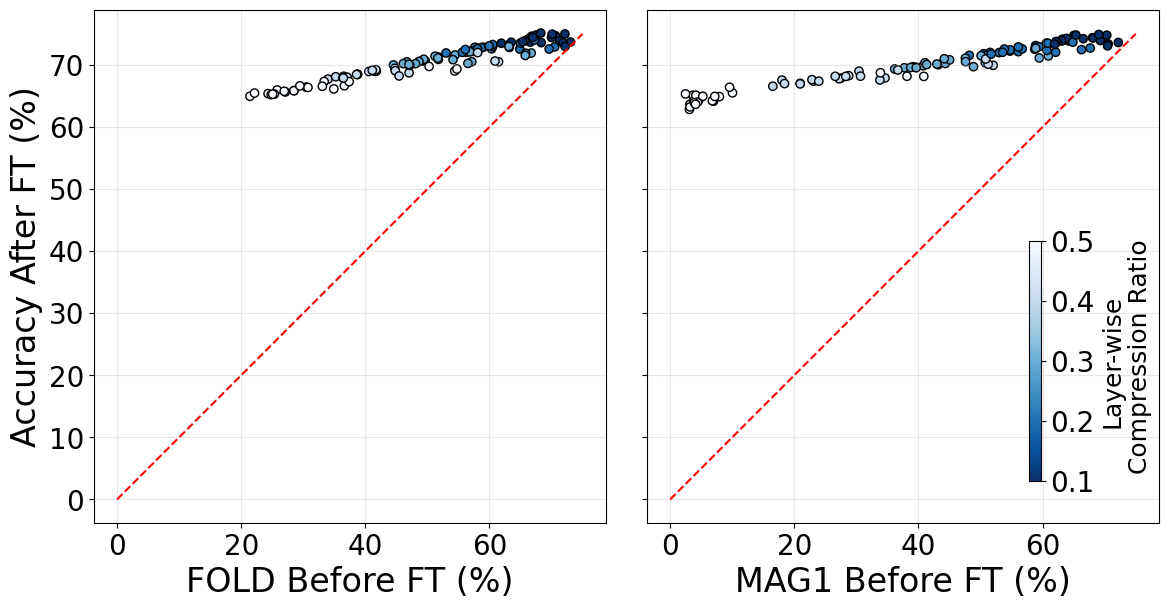

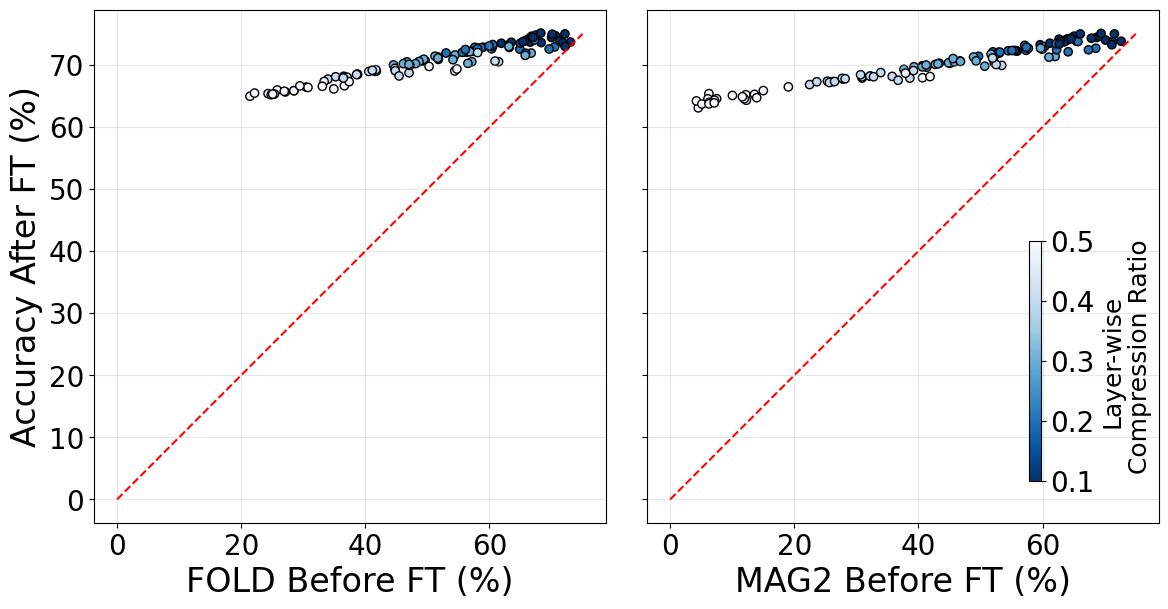

In [ ]:
def extract_before_after_ft(text):
    """Return DataFrame: model_id, ratio, before_acc (PRUNE), after_acc (FINETUNE_EPOCH5)."""
    records = []
    blocks = re.split(r"\[MODEL\]\s+(\d+)/\d+\s+.*?\.pt", text)[1:]

    for i in range(0, len(blocks), 2):
        model_id = int(blocks[i])
        ratio = before = after = None
        for line in blocks[i+1].splitlines():
            if "RATIO=" in line:
                ratio = float(re.search(r"RATIO=([\d.]+)", line).group(1))
            if "EVENT=REPAIR" in line:
                before = float(re.search(r"acc=([\d.]+)", line).group(1))
            if "EVENT=FINETUNE_EPOCH5" in line and before is not None:
                after = float(re.search(r"acc=([\d.]+)", line).group(1))
                records.append((model_id, ratio, before, after))
    return pd.DataFrame(records, columns=["model_id", "ratio", "before_acc", "after_acc"])


# --- Load logs (filter via include/exclude if desired) ---
fold_df = extract_before_after_ft(fold_text)
mag1_df = extract_before_after_ft(mag1_text)
mag2_df = extract_before_after_ft(mag2_text)

for method_name, method_df in zip(["MAG1","MAG2"], [mag1_df, mag2_df]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    combined_ratios = pd.concat([d["ratio"] for d in [fold_df, method_df] if not d.empty])
    norm = mcolors.Normalize(vmin=combined_ratios.min(), vmax=combined_ratios.max())
    cmap = cm.Blues_r

    def plot_method(ax, df, name):
        sc = ax.scatter(
            df["before_acc"], df["after_acc"],
            c=cmap(norm(df["ratio"].values)), edgecolors="black"
        )
        lo = min(df["before_acc"].min(), df["after_acc"].min())
        hi = max(df["before_acc"].max(), df["after_acc"].max())
        lo = 0
        hi = 75
        ax.plot([lo, hi], [lo, hi], 'r--', alpha=1.0)
        ax.set_xlabel(f"{name} Before FT (%)", fontsize=24)
        ax.set_aspect('equal', adjustable='box')
        ax.tick_params(axis='both', labelsize=20)
        return sc

    for ax, tdf, name in zip(axes, [fold_df, method_df], ["FOLD", method_name]):
        if tdf.empty:
            continue
        plot_method(ax, tdf, name)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Accuracy After FT (%)", fontsize=24)


    # Shared colorbar (attach to axes to avoid tight_layout issues)
    cax = fig.add_axes([0.87, 0.19, 0.01, 0.4])
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.set_label("Layer-wise\n Compression Ratio", fontsize=18)
    cbar.ax.tick_params(labelsize=20)

    fig.tight_layout()
    fig.savefig(f"{opt_name}__fold_and_{method_name}_before_and_after_ft.png", dpi=100)
    plt.show()

In [ ]:
!zip out.zip *.png

  adding: clip__compression_ratio_hist__MAG1_vs_FOLD.png (deflated 12%)
  adding: clip__compression_ratio_hist__MAG2_vs_FOLD.png (deflated 11%)
  adding: clip__compression_ratio_scatter__MAG1_vs_FOLD.png (deflated 4%)
  adding: clip__compression_ratio_scatter__MAG2_vs_FOLD.png (deflated 4%)
  adding: clip__fold_and_MAG1_before_and_after_ft.png (deflated 8%)
  adding: clip__fold_and_MAG2_before_and_after_ft.png (deflated 8%)
  adding: clip__fold_vs_MAG1_after_ft_gain.png (deflated 7%)
  adding: clip__fold_vs_MAG1_after_ft.png (deflated 7%)
  adding: clip__fold_vs_MAG2_after_ft_gain.png (deflated 8%)
  adding: clip__fold_vs_MAG2_after_ft.png (deflated 7%)
  adding: clip__ftLN__compression_ratio_hist__MAG1_vs_FOLD.png (deflated 12%)
  adding: clip__ftLN__compression_ratio_hist__MAG2_vs_FOLD.png (deflated 11%)
  adding: clip__ftLN__compression_ratio_scatter__MAG1_vs_FOLD.png (deflated 5%)
  adding: clip__ftLN__compression_ratio_scatter__MAG2_vs_FOLD.png (deflated 5%)
